# Visualizing FashionMNIST

# Load and Visualize FashionMNIST
---
In this notebook, we load and look at images from the [Fashion-MNIST database](https://github.com/zalandoresearch/fashion-mnist).

The first step in any classification problem is to look at the dataset you are working with. This will give you some details about the format of images and labels, as well as some insight into how you might approach defining a network to recognize patterns in such an image set.

PyTorch has some built-in datasets that you can use, and FashionMNIST is one of them; it has already been dowloaded into the `data/` directory in this notebook, so all we have to do is load these images using the FashionMNIST dataset class *and* load the data in batches with a `DataLoader`.


### Load the [data](http://pytorch.org/docs/master/torchvision/datasets.html)

#### Dataset class and Tensors

``torch.utils.data.Dataset`` is an abstract class representing a
dataset. The FashionMNIST class is an extension of this Dataset class and it allows us to 1. load batches of image/label data, and 2. uniformly apply transformations to our data, such as turning all our images into Tensor's for training a neural network. *Tensors are similar to numpy arrays, but can also be used on a GPU to accelerate computing.*

Let's see how to construct a training dataset.


In [23]:
# our basic libraries
import torch
import torchvision

# data loading and transforming
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

# The output of torchvision datasets are PILImage images of range [0, 1]. 
# We transform them to Tensors for input into a CNN

## Define a transform to read the data in as a tensor
data_transform = transforms.ToTensor()

# choose the training and test datasets
train_data = FashionMNIST(root='./data', train=True,
                                   download=True, transform=data_transform)

test_data = FashionMNIST(root='./data', train=False,
                                  download=True, transform=data_transform)


# Print out some stats about the training and test data
print('Train data, number of images: ', len(train_data))
print('Test data, number of images: ', len(test_data))

Train data, number of images:  60000
Test data, number of images:  10000


#### Data iteration and batching

Next, we'll use ``torch.utils.data.DataLoader`` , which is an iterator that allows us to batch and shuffle the data.

In the next cell, we shuffle the data and load in image/label data in batches of size 20.

In [24]:
# prepare data loaders, set the batch_size
## TODO: you can try changing the batch_size to be larger or smaller
## when you get to training your network, see how batch_size affects the loss
batch_size = 20

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Visualize some training data

This cell iterates over the training dataset, loading a random batch of image/label data, using `dataiter.next()`. It then plots the batch of images and labels in a `2 x batch_size/2` grid.

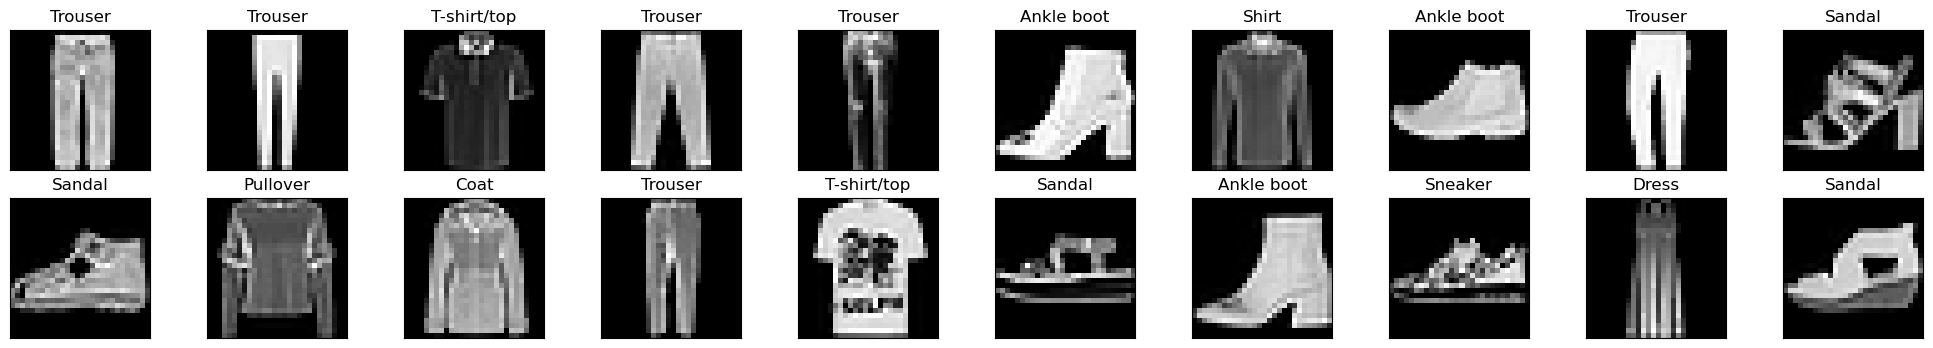

In [25]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)  # Use the next() function
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

plt.show()


### Define the network architecture

The various layers that make up any neural network are documented, [here](http://pytorch.org/docs/master/nn.html). For a convolutional neural network, we'll use a simple series of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected (linear) layers

You are also encouraged to look at adding [dropout layers](http://pytorch.org/docs/stable/nn.html#dropout) to avoid overfitting this data.

---

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

You must place any layers with trainable weights, such as convolutional layers, in the `__init__` function and refer to them in the `forward` functio; any layers or functions that always behave in the same way, such as a pre-defined activation function, may appear in either the `__init__` or the `forward` function. In practice, you'll often see conv/pool layers defined in `__init__` and activations defined in `forward`.

#### Convolutional layer
The first convolution layer has been defined for you, it takes in a 1 channel (grayscale) image and outputs 10 feature maps as output, after convolving the image with 3x3 filters.

#### Flattening

Recall that to move from the output of a convoluttional/pooling layer to a linear layer, you must first flatten your extracted features into a vector. If you've used the deep learning library, Keras, you may have seen this done by `Flatten()`, and in PyTorch you can flatten an input `x` with `x = x.view(x.size(0), -1)`.

### TODO: Define the rest of the layers

It will be up to you to define the other layers in this network; we have some recommendations, but you may change the architecture and parameters as you see fit.

Recommendations/tips:
* Use at least two convolutional layers
* Your output must be a linear layer with 10 outputs (for the 10 classes of clothing)
* Use a dropout layer to avoid overfitting

In [27]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 3)
        # 20 outputs * the 5*5 filtered/pooled map size
        self.fc1 = nn.Linear(20*5*5, 50)

        #Dropout with p=0.4
        self.fc1_drop = nn.Dropout(p=0.4)
        #Finally create 10 output channels (for 10 output classes)
        self.fc2 = nn.Linear(50, 10)


    def forward(self, x):
        #two conv/relu + pool layers 
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # prep for linear layer
        # this line of code is the equivalent of flatten in Keras 
        x = x.view(x.size(0), -1)

        # two linear layers with dropout in between
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = self.fc2(x)

        return x

net = Net()
print(net)
        
    

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [28]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)